#### Putting It All Together

As you might have guessed from the last notebook, using all of the variables was allowing you to drastically overfit the training data.  This was great for looking good in terms of your Rsquared on these points.  However, this was not great in terms of how well you were able to predict on the test data.

We will start where we left off in the last notebook.  First read in the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

In [2]:
# Display all rows of dataframes
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv('./survey-results-public.csv')
df.head().T

,0,1,2,3,4
Respondent,1,2,3,4,5
Professional,Student,Student,Professional developer,Professional non-developer who sometimes write...,Professional developer
ProgramHobby,"Yes, both","Yes, both","Yes, both","Yes, both","Yes, I program as a hobby"
Country,United States,United Kingdom,United Kingdom,United States,Switzerland
University,No,"Yes, full-time",No,No,No
EmploymentStatus,"Not employed, and not looking for work",Employed part-time,Employed full-time,Employed full-time,Employed full-time
FormalEducation,Secondary school,Some college/university study without earning ...,Bachelor's degree,Doctoral degree,Master's degree
MajorUndergrad,NaN,Computer science or software engineering,Computer science or software engineering,A non-computer-focused engineering discipline,Computer science or software engineering
HomeRemote,NaN,"More than half, but not all, the time","Less than half the time, but at least one day ...","Less than half the time, but at least one day ...",Never
CompanySize,NaN,20 to 99 employees,"10,000 or more employees","10,000 or more employees",10 to 19 employees


In [18]:
df.shape[1]

154

In [4]:
df['HaveWorkedFramework'].value_counts()

HaveWorkedFramework
.NET Core                                                                          3201
AngularJS                                                                          2267
Node.js                                                                            2098
AngularJS; Node.js                                                                 1846
Node.js; React                                                                      945
React                                                                               738
AngularJS; .NET Core                                                                653
AngularJS; Node.js; React                                                           615
Firebase                                                                            575
AngularJS; Node.js; .NET Core                                                       505
Node.js; .NET Core                                                                  426
AngularJS; N

In [5]:
research_columns = ['UnderstandComputers', 'SeriousWork', 'InvestTimeTools', 'ChallengeMyself',
                    'CompetePeers', 'ChangeWorld', 'HaveWorkedLanguage', 'WantWorkLanguage', 'HaveWorkedFramework',
                    'WantWorkFramework', 'HighestEducationParents']

In [24]:
def non_nan_barh(df, collist):
    ''' 
    Create horizontal bar graph diagram for the population ratio (non NaN-ratio) of a given dataframe.
    
    INPUT
    df - pandas dataframe 
    collist - Python list with column names to be included in diagram; empty list []: include all columns of dataframe
    '''   
    
    # Calculate the non-NaN value ratio for each column
    if not collist:
        # Empty column list
        non_nan_ratio = df.notna().mean()
    else:
        # Column list is not empty - more focussed bar graph diagram 
        non_nan_ratio = df[research_columns].notna().mean()
        
    nnr_index = non_nan_ratio.index
    non_nan_ratio = non_nan_ratio.iloc[::-1]
        
    # Create a horizontal bar graph
    plt.figure(figsize=(10, len(non_nan_ratio)*0.25))
    non_nan_ratio.plot(kind='barh')  # Change to horizontal bar graph
    plt.title('Non-NaN Value Ratio for Each Column')
    plt.xlabel('Non-NaN Ratio')
    plt.ylabel('Columns')
    plt.xlim(0, 1)  # Set x-axis limits
    plt.grid(axis='x')
    plt.show()

    return

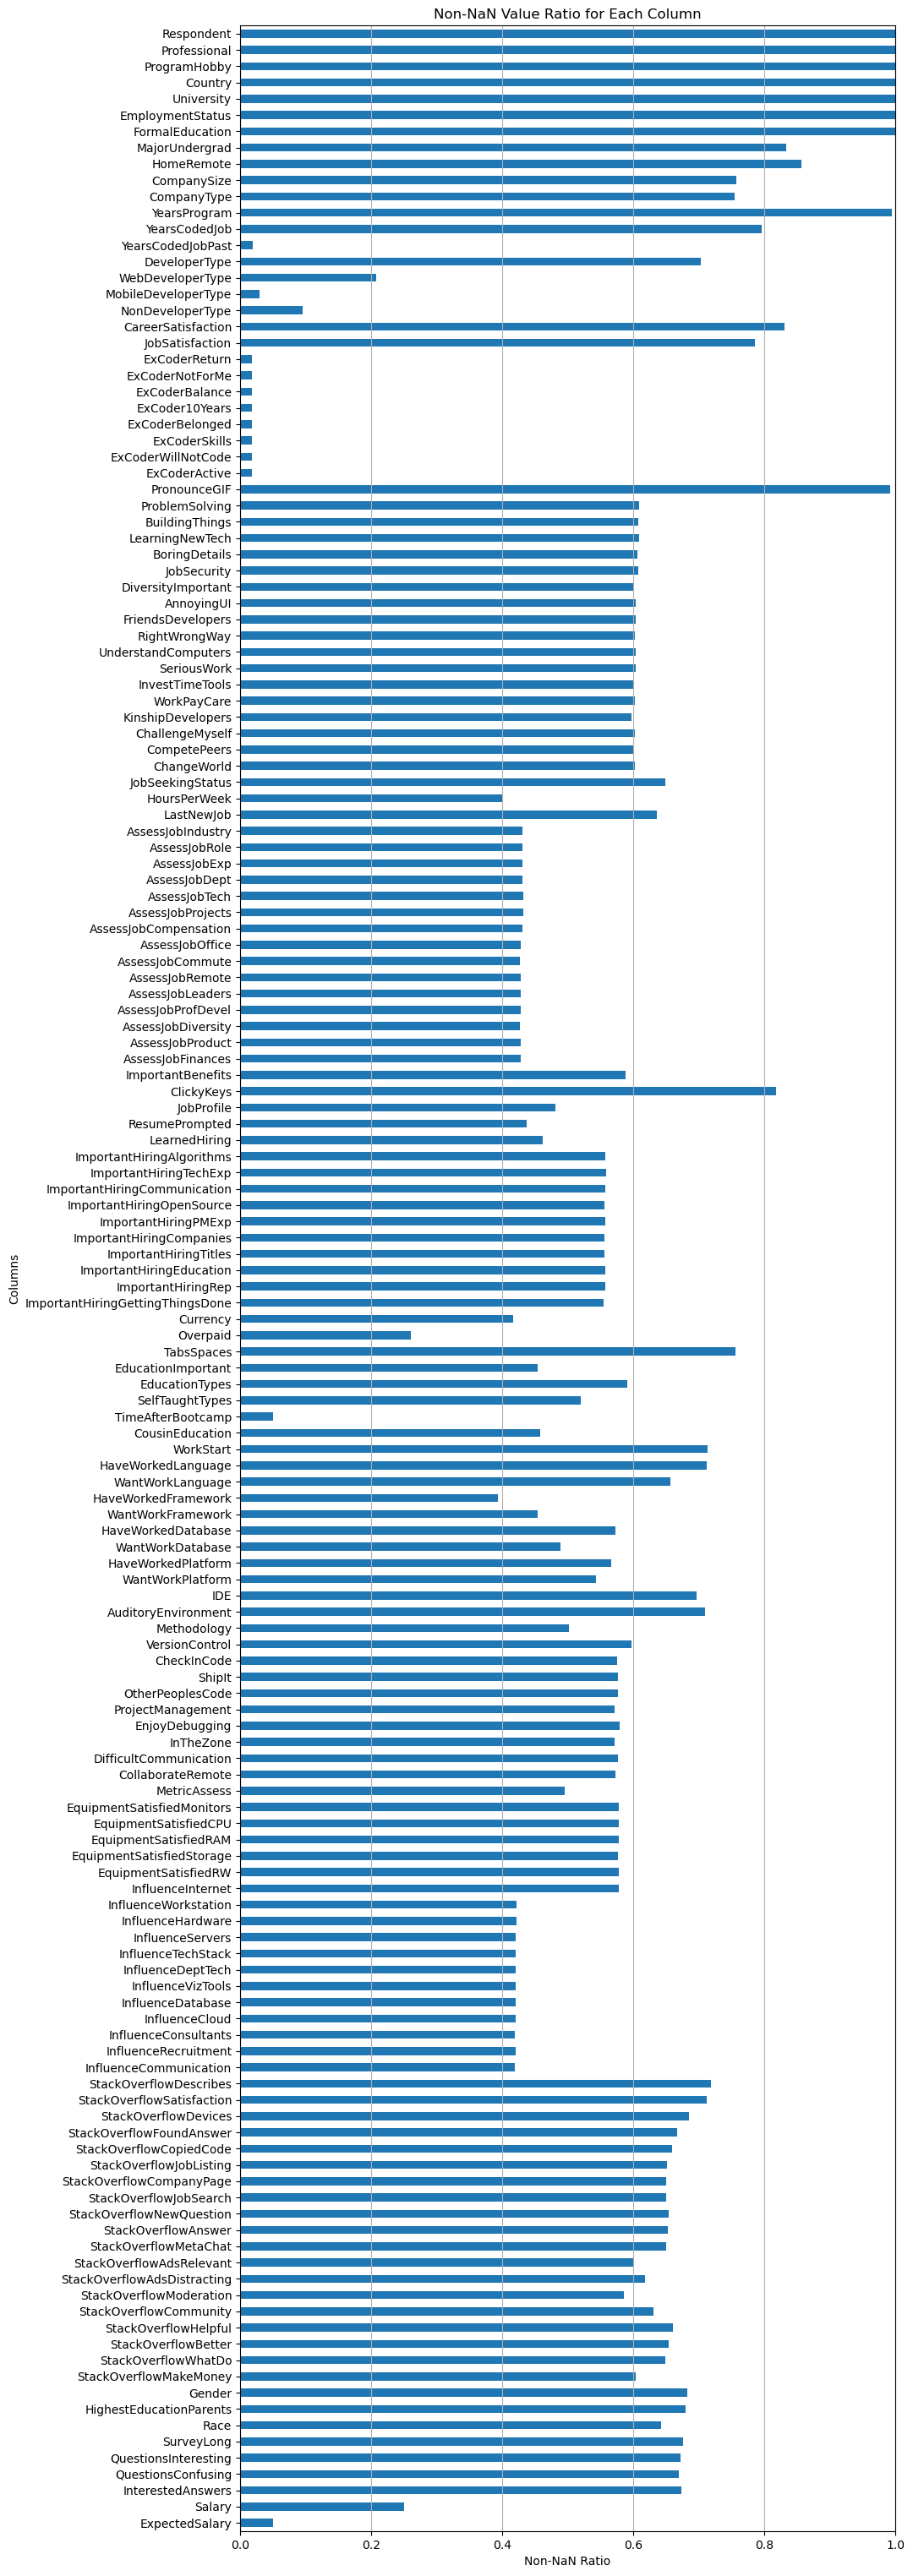

In [25]:
non_nan_barh(df, [])

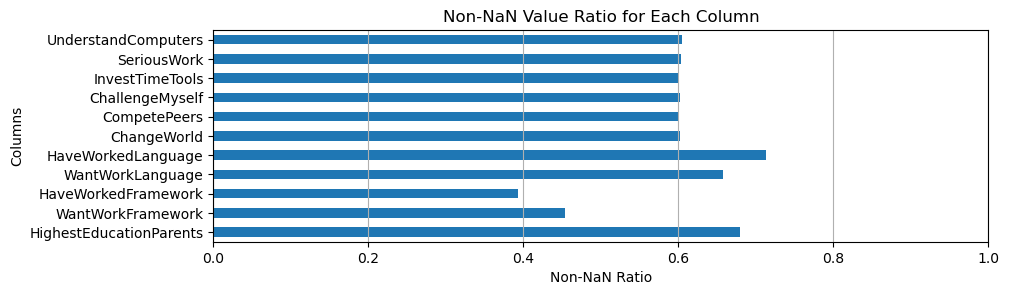

In [26]:
non_nan_barh(df, [research_columns])

In [12]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are not the Salary column
    3. Create y as the Salary column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # Drop rows with missing salary values
    df = df.dropna(subset=['Salary'], axis=0)
    y = df['Salary']
    
    #Drop respondent and expected salary columns
    df = df.drop(['Respondent', 'ExpectedSalary', 'Salary'], axis=1)
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y
    
#Use the function to create X and y
X, y = clean_data(df)    

C:\Users\balbol\AppData\Local\Temp\1\ipykernel_19956\2328966347.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna((df[col].mean()), inplace=True)


In [ ]:
print(X_train.shape[1]) #Number of columns
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2


#### Question 5

**5.** The default penalty on coefficients using linear regression in sklearn is a ridge (also known as an L2) penalty.  Because of this penalty, and that all the variables were normalized, we can look at the size of the coefficients in the model as an indication of the impact of each variable on the salary.  The larger the coefficient, the larger the expected impact on salary.  

Use the space below to take a look at the coefficients.  Then use the results to provide the **True** or **False** statements based on the data.

#### Congrats of some kind

Congrats!  Hopefully this was a great review, or an eye opening experience about how to put the steps together for an analysis. In the next lesson, you will look at how take this and show it off to others so they can act on it.